# Project Briefing

## Objective

The objective of this project is to build classification models that can predict whether a costumer will default on its credit card payment in the following month

## Dataset

The data used refers to costumer's behavior in regards to its credit card payments. It also show whether a costumer has defaulted on its following payment or not. 

The dataset to be used can be found on http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#

# EDA

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

import seaborn as sns
%matplotlib inline

C:\Users\felip\anaconda3\envs\learn-env\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Loading the data

In [2]:
column_legend = pd.read_csv('credit_card_default.csv', header=1).drop('ID', axis=1).columns
df = pd.read_csv('credit_card_default.csv', 
            header=1,
            index_col='ID'
           )

df.reset_index(inplace=True, drop=True)
df.head()




,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6                     30000 non-null int64
PAY_AMT1                

In [4]:
for col in df:
    df[col] = pd.to_numeric(df[col])
    
df.columns = [col.replace(' ', '_') for col in df.columns]



In [5]:
X = df.drop('default_payment_next_month', axis=1)
y = df['default_payment_next_month']


X_train, X_test, y_train, y_test  = train_test_split(X, y, random_state=7)

In [6]:
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))

0    17515
1     4985
Name: default_payment_next_month, dtype: int64
0    0.778444
1    0.221556
Name: default_payment_next_month, dtype: float64


# Helper Functions

In [7]:
def visuals(y, y_hat):
    
    "Plots the ROC Curve"
    fpr, tpr, thresholds = roc_curve(y, 
                                 y_hat)

    area_inder_curve = auc(fpr, tpr)
    
    
    # Seaborn's beautiful styling
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

    print('AUC: {}'.format(area_inder_curve))
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [8]:
def plot_confusion_matrix(y_hat_test, y_test,
                          normalize=False,
                          title='Confusion matrix',
                          ):
    
    "Plots the Confusion Matrix"
    
    cm=confusion_matrix(y_hat_test, y_test)
    classes=y_test.unique()
    cmap=plt.cm.Blues
    
    #Add Normalization Option
    if normalize:
        cm = cm/cm.sum()

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] >= thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
def area_under_curve(X_test, y_test, model):
    "Returns the auc"
    
    
    y_hat_test = model.predict(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_hat_test)
    
    return auc(fpr, tpr)

In [10]:

def resampler(X_train, y_train, n_ratios=10):
    
    "return lists of X_samples, y_samples, ratios after resampling the data with SMOTE"
    
    min_ratio = (y_train.value_counts(normalize=False)[1]
                 /y_train.value_counts(normalize=False)[0])
    ratios = np.linspace(min_ratio,# must be equal or higher than the actual
                         1, 
                         n_ratios) 
    
    X_samples = []
    y_samples = []
    
    for ratio in ratios:
        smote = SMOTE(sampling_strategy=min_ratio)
        X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)
        X_samples.append(X_train_resampled)
        y_samples.append(y_train_resampled)
        
    return X_samples, y_samples, ratios

In [11]:
def grid_search_fit(pipe, X_train, y_train, param_grid, cv=5, scoring='balanced_accuracy'):
    "Performs a Grid Search and returns a fitted model"
    
    grid_search = GridSearchCV(pipe,
                               param_grid=param_grid,
                               scoring=scoring,
                               cv=cv)
    # Fit to the data
    return grid_search.fit(X_train, y_train)

In [12]:
def print_test_metrics(y_test, y_pred):
    "Prints test and train metrics"
    
    
    test_score = round(balanced_accuracy_score(y_test, y_pred),2)
    print('Train score: ', round(best_score, 2))
    print('Test Score:', round(test_score,2))
    print(results = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)))
    visuals(y_test, y_pred)

In [13]:
def model_iterations(X_train, y_train, pipe, param_grid, resampling=False,
                     n_resamples=5,scoring='f1', cv=5):
    
    "Performs a grid search and resampling, prints important metrics and returns a fitted optimal model"




    # implementing SMOTE
    if resampling==True:
        best_score = 0
        X_samples, y_samples, ratios = resampler(X_train, 
                                                 y_train, 
                                                 n_ratios=n_resamples)
        
        for X_train_resampled, y_train_resampled, ratio in zip(X_samples, 
                                                                y_samples, 
                                                                ratios):
            model = grid_search_fit(pipe, X_train_resampled, y_train_resampled,
                                    param_grid, cv=cv, scoring=scoring )
            if model.best_score_ > best_score:
                best_score = model.best_score_
                best_model = model
                best_ratio = ratio
            
            
        
        
    else:
        best_model = grid_search_fit(pipe, X_train, y_train,param_grid,
                        cv=cv, scoring=scoring)
        best_score = best_model.best_score_ 
        ratio=None

    # evaluation metrics
    y_pred = best_model.predict(X_test)
    test_score = round(f1_score(y_test, y_pred),2)
    print('Best SMOTE Ratio: ', ratio)
    print('Best Params:', 
         best_model.best_params_)
    print('Train score: ', round(best_score, 2))
    print('Test Score:', round(test_score,2))

    results = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    
    plot_confusion_matrix(y_pred, y_test,
                          normalize=True,
                          title='Confusion matrix',
                          )
    visuals(y_test, y_pred)
    print('results:\n', results)
    return best_model

# Prediction Models

## Logistic Regression

Best SMOTE Ratio:  1.0
Best Params: {'clf__C': 5, 'clf__solver': 'liblinear', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}
Train score:  0.37
Test Score: 0.36
[[0.75706667 0.1672    ]
 [0.0228     0.05293333]]
AUC: 0.6056122801383785


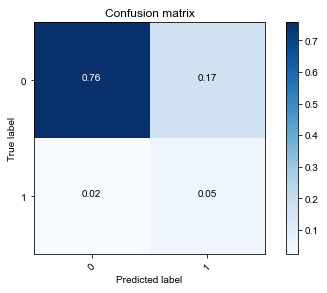

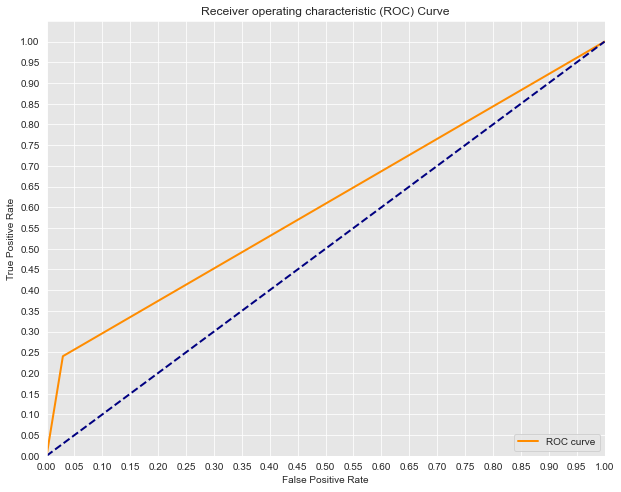

results:
                      0            1  accuracy    macro avg  weighted avg
f1-score      0.888506     0.357819      0.81     0.623163      0.771684
precision     0.819100     0.698944      0.81     0.759022      0.792649
recall        0.970764     0.240460      0.81     0.605612      0.810000
support    5849.000000  1651.000000      0.81  7500.000000   7500.000000


In [14]:
estimators_log_reg = [('scaler', MinMaxScaler()), 
              ('clf', LogisticRegression(max_iter=1000))]

param_grid_log_reg = dict(scaler=[MinMaxScaler(), StandardScaler()],
                  clf__C= [0.9, 1, 1.1, 2, 5],
                 clf__solver=['liblinear']),# 'lbfgs'])
pipe_log_reg = Pipeline(estimators_log_reg)


best_model_f1_smote = model_iterations(X_train, y_train, pipe_log_reg, param_grid_log_reg, resampling=True,
                     n_resamples=2,scoring='f1', cv=5)

## K-Nearest Neighbors

Best SMOTE Ratio:  1.0
Best Params: {'clf__algorithm': 'auto', 'clf__leaf_size': 2, 'clf__n_neighbors': 11, 'clf__p': 2, 'clf__weights': 'distance', 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1))}
Train score:  0.44
Test Score: 0.42
[[0.73093333 0.14786667]
 [0.04893333 0.07226667]]
AUC: 0.6327700594167841


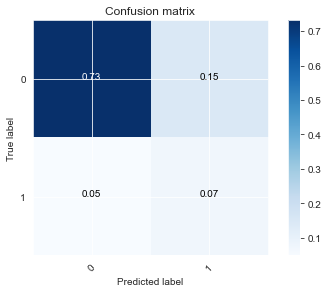

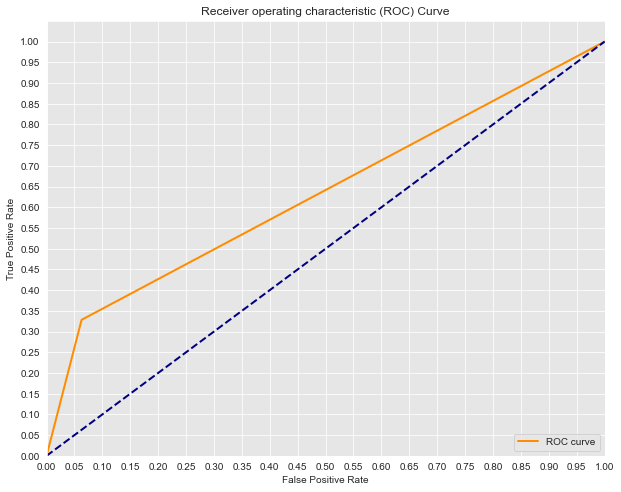

results:
                      0            1  accuracy    macro avg  weighted avg
f1-score      0.881350     0.423437    0.8032     0.652394      0.780549
precision     0.831740     0.596260    0.8032     0.714000      0.779903
recall        0.937254     0.328286    0.8032     0.632770      0.803200
support    5849.000000  1651.000000    0.8032  7500.000000   7500.000000


In [15]:
estimators_kneigh = [('scaler', MinMaxScaler()), 
              ('clf', KNeighborsClassifier())]

param_grid_kneigh = dict(scaler=[MinMaxScaler()],# StandardScaler()],
                  clf__n_neighbors= [11],#list(range(3, 103, 2)),
                  clf__weights = ['uniform', 'distance'],
                  clf__leaf_size = list(range(2, 20,4)),
                  clf__p = [2],#1, 2, 3, 5],
                  clf__algorithm=['auto'])# 'ball_tree', 'kd_tree', 'brute'])
pipe_kneigh = Pipeline(estimators_kneigh)


best_model_kneighbors = model_iterations(X_train, y_train, pipe_kneigh, param_grid_kneigh, resampling=True,
                     n_resamples=3,scoring='f1', cv=5)

## Naive Bayes

Best SMOTE Ratio:  1.0
Best Params: {'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}
Train score:  0.48
Test Score: 0.47
[[0.50373333 0.068     ]
 [0.27613333 0.15213333]]
AUC: 0.6685093425817663


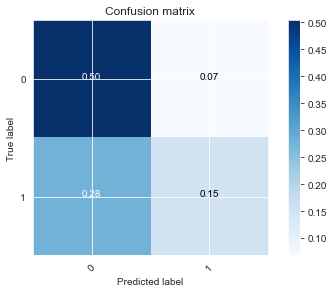

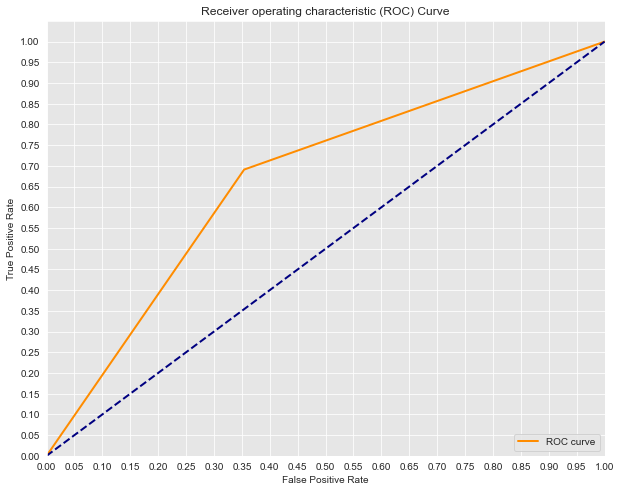

results:
                      0            1  accuracy    macro avg  weighted avg
f1-score      0.745388     0.469258  0.655867     0.607323      0.684603
precision     0.881063     0.355230  0.655867     0.618147      0.765310
recall        0.645922     0.691096  0.655867     0.668509      0.655867
support    5849.000000  1651.000000  0.655867  7500.000000   7500.000000


In [16]:
estimators_bayes = [('scaler', StandardScaler()), 
              ('clf', GaussianNB())]

param_grid_bayes = dict(scaler=[StandardScaler(), MinMaxScaler()])
pipe_bayes = Pipeline(estimators_bayes)

best_model_bayes = model_iterations(X_train, y_train, pipe_bayes, param_grid_bayes, resampling=True,
                     n_resamples=5, scoring='f1', cv=5)


## Decision Tree Classifier

Best SMOTE Ratio:  None
Best Params: {'clf__criterion': 'gini', 'clf__max_depth': 7, 'clf__max_features': None, 'clf__min_samples_leaf': 26, 'clf__min_samples_split': 0.028}
Train score:  0.47
Test Score: 0.47
[[0.7408     0.14013333]
 [0.03906667 0.08      ]]
AUC: 0.6566610391397723


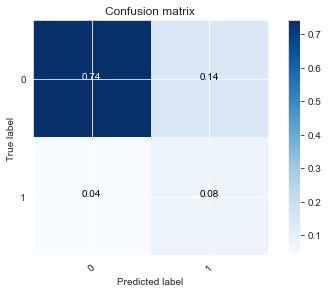

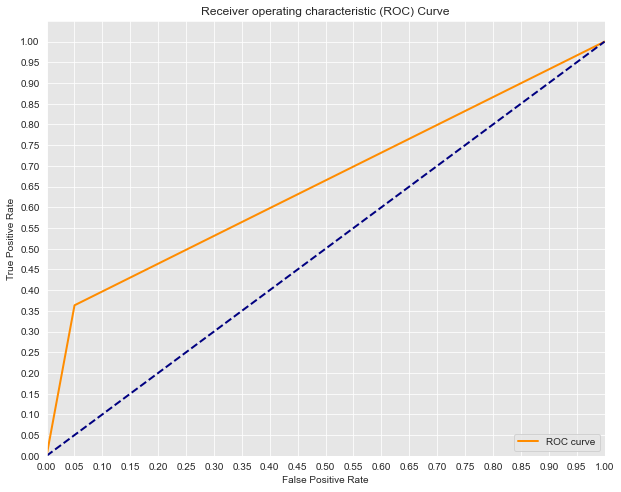

results:
                      0            1  accuracy    macro avg  weighted avg
f1-score      0.892100     0.471698    0.8208     0.681899      0.799556
precision     0.840926     0.671892    0.8208     0.756409      0.803716
recall        0.949906     0.363416    0.8208     0.656661      0.820800
support    5849.000000  1651.000000    0.8208  7500.000000   7500.000000


In [17]:
estimators_dt = [('clf', DecisionTreeClassifier())]

param_dt = dict(clf__criterion = ['gini'],
                clf__max_depth = [7], 
                clf__min_samples_split = [0.028],# np.linspace(0.01, 0.10, 10),
                clf__min_samples_leaf = [26],
                clf__max_features = [None],
               )
                
pipe_dt = Pipeline(estimators_dt)


best_model_dt = model_iterations(X_train, y_train, pipe_dt, param_dt, resampling=False,
                     n_resamples=3,scoring='f1', cv=5)


## Ensemble Methods

### Bagged Trees

best_score: 0.4460732830899205
[[0.74706667 0.14786667]
 [0.0328     0.07226667]]


,0,1,accuracy,macro avg,weighted avg
f1-score,0.892126,0.444444,0.819333,0.668285,0.793577
precision,0.834774,0.687817,0.819333,0.761295,0.802424
recall,0.957942,0.328286,0.819333,0.643114,0.819333
support,5849.000000,1651.000000,0.819333,7500.000000,7500.000000


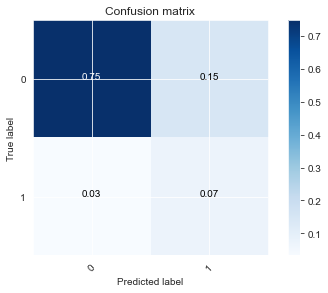

In [18]:

param_bc = {
    'base_estimator__max_depth' : [2],
    'base_estimator__min_samples_split' : [0.13],
    'base_estimator__min_samples_leaf' : [10],
    'base_estimator__criterion' : ['gini'],
    'max_samples' : [0.7],
    'max_features': [0.7],
    'n_estimators': [50]}
                
cv = GridSearchCV(BaggingClassifier(DecisionTreeClassifier()),
                   param_bc, scoring = 'f1')

cv.fit(X_train, y_train)
print('best_score:',cv.best_score_)

y_hat_bc = cv.predict(X_test)

plot_confusion_matrix(y_hat_bc, y_test,
                          normalize=True,
                          title='Confusion matrix',
                          )

pd.DataFrame(classification_report(y_test, y_hat_bc, output_dict=True))

### Random Forest

best_score: 0.5438605139608929
[[0.64786667 0.09453333]
 [0.132      0.1256    ]]


,0,1,accuracy,macro avg,weighted avg
f1-score,0.851187,0.525816,0.773467,0.688502,0.779562
precision,0.872665,0.487578,0.773467,0.680121,0.787895
recall,0.830740,0.570563,0.773467,0.700652,0.773467
support,5849.000000,1651.000000,0.773467,7500.000000,7500.000000


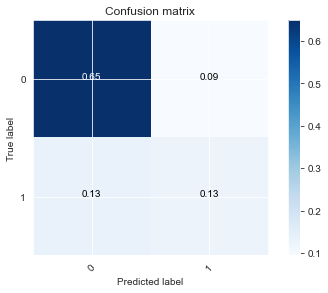

In [19]:

param_rf = {
    'max_depth' : [2, 3, 4, 5, 6],
    'bootstrap': [True],
    'class_weight' : ['balanced'], #[None, 'balanced', {1:2, 0:1}, {1:10, 0:1}, {1:100, 0:1}],
    #'min_samples_split' : [0.01], #[0.05, 0.1, 0.2, 0.3, 0.4],
    #'min_samples_leaf' : [5],
    'criterion' :['entropy'],
    'max_features': [0.2, 0.5, 0.7],
    'n_estimators': [50]}



cv_rf = GridSearchCV(RandomForestClassifier(), 
                     param_rf, scoring = 'f1')

cv_rf.fit(X_train, y_train)
print('best_score:', cv_rf.best_score_)

y_hat_rf = cv_rf.predict(X_test)

plot_confusion_matrix(y_hat_rf, y_test,
                          normalize=True,
                          title='Confusion matrix',
                          )

pd.DataFrame(classification_report(y_test, y_hat_rf, output_dict=True))

## XGBoost

best training score: 0.4714134462678666
[[0.7432     0.1432    ]
 [0.03666667 0.07693333]]


,0,1,accuracy,macro avg,weighted avg
f1-score,0.892054,0.461047,0.820133,0.676550,0.797175
precision,0.838448,0.677230,0.820133,0.757839,0.802958
recall,0.952983,0.349485,0.820133,0.651234,0.820133
support,5849.000000,1651.000000,0.820133,7500.000000,7500.000000


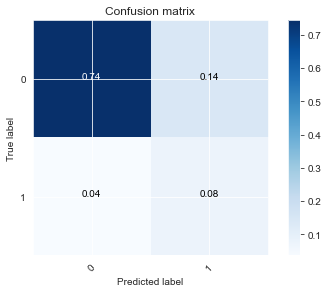

In [20]:
estimators_xg = [('scaler', StandardScaler()), 
              ('clf', xgb.XGBClassifier())]



param_grid_xg = dict(clf__learning_rate= [0.1],
                     clf__class_weight = [dict({0:1, 1:100})
                                         ],
                     clf__max_depth = [2],#, 5, 8], 
                     clf__subsample= [0.7], 
                     clf__n_estimators= [30, 50, 100],
                     clf__gamma = [10],
                     clf__verbosity = [1],
                     clf__booster= ['gbtree']
                    )
pipe_xg = Pipeline(estimators_xg)

cv_xg = GridSearchCV(pipe_xg, 
                     param_grid_xg, scoring = 'f1')

cv_xg.fit(X_train, y_train)

y_train_hat_xg = cv_xg.predict(X_train)

print('best training score:',f1_score(y_train, y_train_hat_xg))
y_hat_xg = cv_xg.predict(X_test)


plot_confusion_matrix(y_hat_xg, y_test,
                          normalize=True,
                          title='Confusion matrix',
                          )

pd.DataFrame(classification_report(y_test, y_hat_xg, output_dict=True))